## Import thư viện

In [1]:
import torch
from torch import nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchsummary
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
import json
import os

## Model

In [2]:
# For Resnet34 and below

class BuildingBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BuildingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)       
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [3]:
# For Resnet50 and above

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)       
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += self.shortcut(x)
        out = self.relu(out)
        return out
        

In [4]:
class Resnet(nn.Module):
    def __init__(self, block, num_blocks, kernel_size=7, stride=2, padding=3, num_classes=1000):
        super(Resnet, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) #ImageNet

        self.conv2_x = self.make_layer(block, 64, num_blocks[0])
        self.conv3_x = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.conv4_x = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.conv5_x = self.make_layer(block, 512, num_blocks[3], stride=2) #ImageNet

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = block.expansion * out_channels
        for idx in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x) #ImageNet

        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x) #ImageNet

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [5]:
class Resnet18(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=BuildingBlock,
            num_blocks=[2, 2, 2, 2],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

class Resnet34(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=BuildingBlock,
            num_blocks=[3, 4, 6, 3],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

class Resnet50(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=Bottleneck,
            num_blocks=[3, 4, 6, 3],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

class Resnet101(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=Bottleneck,
            num_blocks=[3, 4, 23, 3],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

class Resnet152(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=Bottleneck,
            num_blocks=[3, 8, 36, 3],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

In [6]:
model = Resnet50(kernel_size=3, stride=1, padding=1, num_classes=100)
torchsummary.summary(model)
x = torch.randn(5, 3, 32, 32)
out = model(x)
out.shape

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,728
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─Sequential: 1-4                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  4,096
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    |    └─Conv2d: 3-6                  16,384
|    |    └─BatchNorm2d: 3-7             512
|    |    └─Sequential: 3-8              16,896
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  16,384
|    |    └─BatchNorm2d: 3-10            128
|    |    └─ReLU: 3-11                   --
|    |    └─Conv2d: 3-12                 36,864
|    |    └─BatchNorm2d: 3-13            128
|    |    └─Conv2d: 3-14                 16,384
|    |    └─BatchNorm2d: 3-15      

torch.Size([5, 100])

## Cifar100

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Prepare data

In [8]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])


trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


### Config

In [ ]:
checkpoint_id = 2
folder_path = f'./Resnet/Cifar100/checkpoint{checkpoint_id}/'
kernel_size = 3
stride = 1
padding = 1
num_classes = len(trainset.classes)
batch_size = 256
num_epochs = 100
learning_rate = 0.001
step_size = 50

os.makedirs(folder_path, exist_ok=True)

config = {
    "checkpoint_id": checkpoint_id,
    "folder_path": folder_path,
    "model": 'Resnet34',
    "kernel_size": kernel_size,
    "stride": stride,
    "padding": padding,
    "num_classes": num_classes,
    "batch_size": batch_size,
    "num_epochs": num_epochs,
    "learning_rate": learning_rate,
    "step_size": step_size
}

with open(folder_path + "config.json", "w") as f:
    json.dump(config, f, indent=4)

In [10]:
model = Resnet34(kernel_size, stride, padding, num_classes).to(device)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)
print(model)

Resnet34(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2_x): Sequential(
    (0): BuildingBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BuildingBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


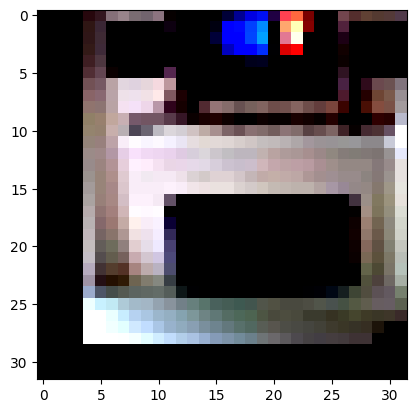

In [11]:
data_iter = iter(trainloader)
images, labels = next(data_iter)

image = images[0].permute(1, 2, 0).numpy()

plt.imshow(image)

In [12]:
print(f'Size: {image.size}')
print(f'Train: {len(trainset)}')
print(f'Test: {len(testset)}')
print(f'Classes: {len(trainset.classes)}')

Size: 3072
Train: 50000
Test: 10000
Classes: 100


### Train, test

In [ ]:
def train(model, trainloader, criterion, optimizer, scheduler, device, folder_path, num_epochs=10):
    model.train()
    epoch_losses = []
    start = time.time()
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            # print(i)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad() 

            outputs = model(inputs) 
            loss = criterion(outputs, labels)  
            loss.backward()
            optimizer.step() 

            running_loss += loss.item()
        running_loss = running_loss / len(trainloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}')
        epoch_losses.append(running_loss)
        scheduler.step()
    end = time.time()
    training_time = (end - start) / 3600

    plt.plot(range(1, num_epochs + 1), epoch_losses)
    plt.title('Training Loss per Epoch')
    plt.suptitle(f'Training time: {training_time:.2f} hours')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(folder_path + 'training_loss.png')
    plt.show()

    torch.save(model.state_dict(), folder_path + 'model_weights.pth')

def evaluate(model, testloader, device, folder_path):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    correct = sum([1 for a, p in zip(all_labels, all_predictions) if a == p])
    total = len(all_labels)
    accuracy = 100 * correct / total
    report = classification_report(all_labels, all_predictions)
    print(f'Accuracy: {accuracy:.2f}%')
    print("Classification Report:")
    print(report)

    with open(folder_path + 'report.txt', "w") as f:
        f.write(f'Accuracy: {accuracy:.2f}%\n')
        f.write("Classification Report:\n\n")
        f.write(report)
    

  1%|          | 1/100 [01:33<2:33:50, 93.24s/it]

Epoch [1/100], Loss: 4.0294


  2%|▏         | 2/100 [03:05<2:31:09, 92.54s/it]

Epoch [2/100], Loss: 3.4854


  3%|▎         | 3/100 [04:36<2:28:36, 91.92s/it]

Epoch [3/100], Loss: 3.0245


  4%|▍         | 4/100 [06:07<2:26:35, 91.61s/it]

Epoch [4/100], Loss: 2.6371


  5%|▌         | 5/100 [07:38<2:24:47, 91.45s/it]

Epoch [5/100], Loss: 2.3259


  6%|▌         | 6/100 [09:09<2:23:08, 91.37s/it]

Epoch [6/100], Loss: 2.1041


  7%|▋         | 7/100 [10:42<2:22:15, 91.78s/it]

Epoch [7/100], Loss: 1.9132


  8%|▊         | 8/100 [12:15<2:21:19, 92.16s/it]

Epoch [8/100], Loss: 1.7654


  9%|▉         | 9/100 [13:48<2:20:12, 92.44s/it]

Epoch [9/100], Loss: 1.6374


 10%|█         | 10/100 [15:21<2:19:00, 92.67s/it]

Epoch [10/100], Loss: 1.5361


 11%|█         | 11/100 [16:54<2:17:39, 92.81s/it]

Epoch [11/100], Loss: 1.4427


 12%|█▏        | 12/100 [18:28<2:16:14, 92.89s/it]

Epoch [12/100], Loss: 1.3790


 13%|█▎        | 13/100 [20:01<2:14:48, 92.97s/it]

Epoch [13/100], Loss: 1.3158


 14%|█▍        | 14/100 [21:34<2:13:19, 93.02s/it]

Epoch [14/100], Loss: 1.2585


 15%|█▌        | 15/100 [23:07<2:11:47, 93.03s/it]

Epoch [15/100], Loss: 1.2110


 16%|█▌        | 16/100 [24:40<2:10:13, 93.02s/it]

Epoch [16/100], Loss: 1.1585


 17%|█▋        | 17/100 [26:13<2:08:41, 93.03s/it]

Epoch [17/100], Loss: 1.1314


 18%|█▊        | 18/100 [27:46<2:07:10, 93.06s/it]

Epoch [18/100], Loss: 1.0877


 19%|█▉        | 19/100 [29:19<2:05:38, 93.07s/it]

Epoch [19/100], Loss: 1.0666


 20%|██        | 20/100 [30:53<2:04:13, 93.16s/it]

Epoch [20/100], Loss: 1.0281


 21%|██        | 21/100 [32:26<2:02:37, 93.13s/it]

Epoch [21/100], Loss: 1.0027


 22%|██▏       | 22/100 [33:59<2:01:00, 93.08s/it]

Epoch [22/100], Loss: 0.9776


 23%|██▎       | 23/100 [35:31<1:59:23, 93.03s/it]

Epoch [23/100], Loss: 0.9571


 24%|██▍       | 24/100 [37:04<1:57:47, 92.99s/it]

Epoch [24/100], Loss: 0.9328


 25%|██▌       | 25/100 [38:37<1:56:12, 92.96s/it]

Epoch [25/100], Loss: 0.9128


 26%|██▌       | 26/100 [40:10<1:54:38, 92.96s/it]

Epoch [26/100], Loss: 0.8963


 27%|██▋       | 27/100 [41:43<1:53:01, 92.90s/it]

Epoch [27/100], Loss: 0.8757


 28%|██▊       | 28/100 [43:16<1:51:32, 92.95s/it]

Epoch [28/100], Loss: 0.8664


 29%|██▉       | 29/100 [44:49<1:50:05, 93.03s/it]

Epoch [29/100], Loss: 0.8397


 30%|███       | 30/100 [46:23<1:48:43, 93.19s/it]

Epoch [30/100], Loss: 0.8360


 31%|███       | 31/100 [47:56<1:47:14, 93.26s/it]

Epoch [31/100], Loss: 0.8266


 32%|███▏      | 32/100 [49:29<1:45:33, 93.13s/it]

Epoch [32/100], Loss: 0.7995


 33%|███▎      | 33/100 [51:02<1:43:56, 93.08s/it]

Epoch [33/100], Loss: 0.7896


 34%|███▍      | 34/100 [52:35<1:42:18, 93.01s/it]

Epoch [34/100], Loss: 0.7793


 35%|███▌      | 35/100 [54:08<1:40:45, 93.00s/it]

Epoch [35/100], Loss: 0.7750


 36%|███▌      | 36/100 [55:41<1:39:12, 93.01s/it]

Epoch [36/100], Loss: 0.7572


 37%|███▋      | 37/100 [57:14<1:37:40, 93.02s/it]

Epoch [37/100], Loss: 0.7440


 38%|███▊      | 38/100 [58:47<1:36:04, 92.97s/it]

Epoch [38/100], Loss: 0.7454


 39%|███▉      | 39/100 [1:00:20<1:34:29, 92.95s/it]

Epoch [39/100], Loss: 0.7344


 40%|████      | 40/100 [1:01:53<1:32:55, 92.92s/it]

Epoch [40/100], Loss: 0.7179


 41%|████      | 41/100 [1:03:25<1:31:22, 92.93s/it]

Epoch [41/100], Loss: 0.7076


 42%|████▏     | 42/100 [1:04:58<1:29:50, 92.93s/it]

Epoch [42/100], Loss: 0.7031


 43%|████▎     | 43/100 [1:06:31<1:28:16, 92.92s/it]

Epoch [43/100], Loss: 0.6990


 44%|████▍     | 44/100 [1:08:04<1:26:42, 92.90s/it]

Epoch [44/100], Loss: 0.6966


 45%|████▌     | 45/100 [1:09:37<1:25:08, 92.88s/it]

Epoch [45/100], Loss: 0.6838


 46%|████▌     | 46/100 [1:11:10<1:23:36, 92.89s/it]

Epoch [46/100], Loss: 0.6741


 47%|████▋     | 47/100 [1:12:43<1:22:05, 92.94s/it]

Epoch [47/100], Loss: 0.6673


 48%|████▊     | 48/100 [1:14:16<1:20:35, 92.99s/it]

Epoch [48/100], Loss: 0.6695


 49%|████▉     | 49/100 [1:15:49<1:19:01, 92.98s/it]

Epoch [49/100], Loss: 0.6647


 50%|█████     | 50/100 [1:17:22<1:17:27, 92.95s/it]

Epoch [50/100], Loss: 0.6424


 51%|█████     | 51/100 [1:18:55<1:15:52, 92.91s/it]

Epoch [51/100], Loss: 0.4254


 52%|█████▏    | 52/100 [1:20:28<1:14:18, 92.89s/it]

Epoch [52/100], Loss: 0.3363


 53%|█████▎    | 53/100 [1:22:01<1:12:50, 92.98s/it]

Epoch [53/100], Loss: 0.2984


 54%|█████▍    | 54/100 [1:23:34<1:11:18, 93.01s/it]

Epoch [54/100], Loss: 0.2724


 55%|█████▌    | 55/100 [1:25:07<1:09:43, 92.96s/it]

Epoch [55/100], Loss: 0.2528


 56%|█████▌    | 56/100 [1:26:40<1:08:10, 92.96s/it]

Epoch [56/100], Loss: 0.2353


 57%|█████▋    | 57/100 [1:28:13<1:06:40, 93.02s/it]

Epoch [57/100], Loss: 0.2179


 58%|█████▊    | 58/100 [1:29:44<1:04:45, 92.50s/it]

Epoch [58/100], Loss: 0.2075


 59%|█████▉    | 59/100 [1:31:16<1:03:10, 92.45s/it]

Epoch [59/100], Loss: 0.1938


 60%|██████    | 60/100 [1:32:51<1:01:57, 92.94s/it]

Epoch [60/100], Loss: 0.1826


 61%|██████    | 61/100 [1:34:24<1:00:29, 93.06s/it]

Epoch [61/100], Loss: 0.1702


 62%|██████▏   | 62/100 [1:35:57<58:56, 93.07s/it]  

Epoch [62/100], Loss: 0.1631


 63%|██████▎   | 63/100 [1:37:30<57:18, 92.93s/it]

Epoch [63/100], Loss: 0.1525


 64%|██████▍   | 64/100 [1:39:02<55:38, 92.74s/it]

Epoch [64/100], Loss: 0.1449


 65%|██████▌   | 65/100 [1:40:34<54:00, 92.58s/it]

Epoch [65/100], Loss: 0.1375


 66%|██████▌   | 66/100 [1:42:07<52:31, 92.70s/it]

Epoch [66/100], Loss: 0.1320


 67%|██████▋   | 67/100 [1:43:40<51:01, 92.78s/it]

Epoch [67/100], Loss: 0.1251


 68%|██████▊   | 68/100 [1:45:13<49:33, 92.93s/it]

Epoch [68/100], Loss: 0.1179


 69%|██████▉   | 69/100 [1:46:47<48:05, 93.08s/it]

Epoch [69/100], Loss: 0.1120


 70%|███████   | 70/100 [1:48:20<46:34, 93.16s/it]

Epoch [70/100], Loss: 0.1077


 71%|███████   | 71/100 [1:49:53<45:02, 93.18s/it]

Epoch [71/100], Loss: 0.1038


 72%|███████▏  | 72/100 [1:51:26<43:28, 93.16s/it]

Epoch [72/100], Loss: 0.0962


 73%|███████▎  | 73/100 [1:52:59<41:54, 93.13s/it]

Epoch [73/100], Loss: 0.0953


 74%|███████▍  | 74/100 [1:54:32<40:20, 93.08s/it]

Epoch [74/100], Loss: 0.0909


 75%|███████▌  | 75/100 [1:56:05<38:46, 93.04s/it]

Epoch [75/100], Loss: 0.0881


 76%|███████▌  | 76/100 [1:57:38<37:11, 92.98s/it]

Epoch [76/100], Loss: 0.0871


 77%|███████▋  | 77/100 [1:59:11<35:38, 92.97s/it]

Epoch [77/100], Loss: 0.0828


 78%|███████▊  | 78/100 [2:00:44<34:05, 92.99s/it]

Epoch [78/100], Loss: 0.0784


 79%|███████▉  | 79/100 [2:02:17<32:31, 92.95s/it]

Epoch [79/100], Loss: 0.0785


 80%|████████  | 80/100 [2:03:50<30:58, 92.92s/it]

Epoch [80/100], Loss: 0.0747


 81%|████████  | 81/100 [2:05:23<29:27, 93.02s/it]

Epoch [81/100], Loss: 0.0755


 82%|████████▏ | 82/100 [2:06:56<27:54, 93.04s/it]

Epoch [82/100], Loss: 0.0720


 83%|████████▎ | 83/100 [2:08:29<26:21, 93.04s/it]

Epoch [83/100], Loss: 0.0727


 84%|████████▍ | 84/100 [2:10:03<24:52, 93.26s/it]

Epoch [84/100], Loss: 0.0703


 85%|████████▌ | 85/100 [2:11:36<23:18, 93.22s/it]

Epoch [85/100], Loss: 0.0660


 86%|████████▌ | 86/100 [2:13:10<21:47, 93.42s/it]

Epoch [86/100], Loss: 0.0643


 87%|████████▋ | 87/100 [2:14:43<20:14, 93.39s/it]

Epoch [87/100], Loss: 0.0639


 88%|████████▊ | 88/100 [2:16:16<18:38, 93.25s/it]

Epoch [88/100], Loss: 0.0624


 89%|████████▉ | 89/100 [2:17:49<17:04, 93.15s/it]

Epoch [89/100], Loss: 0.0653


 90%|█████████ | 90/100 [2:19:23<15:33, 93.40s/it]

Epoch [90/100], Loss: 0.0655


 91%|█████████ | 91/100 [2:20:56<13:58, 93.22s/it]

Epoch [91/100], Loss: 0.0619


 92%|█████████▏| 92/100 [2:22:28<12:22, 92.77s/it]

Epoch [92/100], Loss: 0.0619


 93%|█████████▎| 93/100 [2:24:00<10:47, 92.48s/it]

Epoch [93/100], Loss: 0.0585


 94%|█████████▍| 94/100 [2:25:31<09:13, 92.32s/it]

Epoch [94/100], Loss: 0.0575


 95%|█████████▌| 95/100 [2:27:04<07:41, 92.29s/it]

Epoch [95/100], Loss: 0.0564


 96%|█████████▌| 96/100 [2:28:35<06:08, 92.03s/it]

Epoch [96/100], Loss: 0.0577


 97%|█████████▋| 97/100 [2:30:06<04:35, 91.75s/it]

Epoch [97/100], Loss: 0.0551


 98%|█████████▊| 98/100 [2:31:37<03:03, 91.53s/it]

Epoch [98/100], Loss: 0.0536


 99%|█████████▉| 99/100 [2:33:08<01:31, 91.33s/it]

Epoch [99/100], Loss: 0.0539


100%|██████████| 100/100 [2:34:39<00:00, 92.80s/it]

Epoch [100/100], Loss: 0.0549


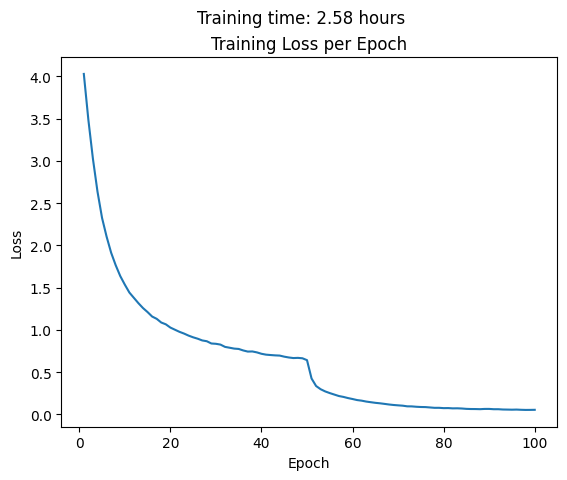

<Figure size 640x480 with 0 Axes>

In [14]:
train(model, trainloader, criterion, optimizer, scheduler, device, folder_path, num_epochs=num_epochs)

In [15]:
evaluate(model, testloader, device, folder_path)

Accuracy: 71.53%
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       100
           1       0.76      0.83      0.79       100
           2       0.65      0.62      0.63       100
           3       0.65      0.52      0.58       100
           4       0.54      0.65      0.59       100
           5       0.73      0.72      0.72       100
           6       0.75      0.77      0.76       100
           7       0.80      0.67      0.73       100
           8       0.88      0.84      0.86       100
           9       0.88      0.85      0.86       100
          10       0.57      0.51      0.54       100
          11       0.62      0.44      0.51       100
          12       0.77      0.79      0.78       100
          13       0.59      0.68      0.63       100
          14       0.65      0.69      0.67       100
          15       0.74      0.80      0.77       100
          16       0.77      0.73      0.